Relative error: 5.30e-02
Iterations: 343, Final Residual Norm: 9.51e-11


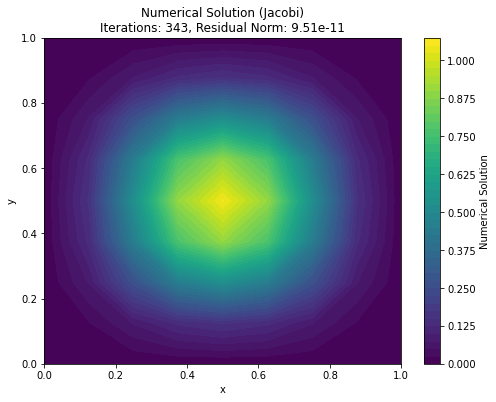

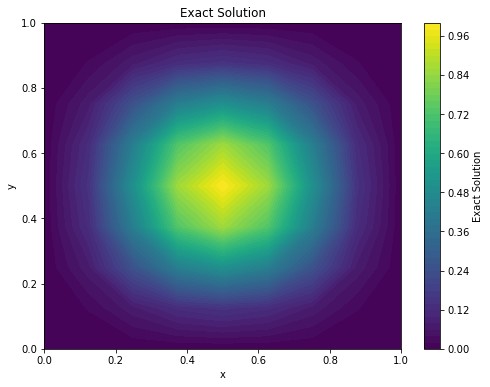

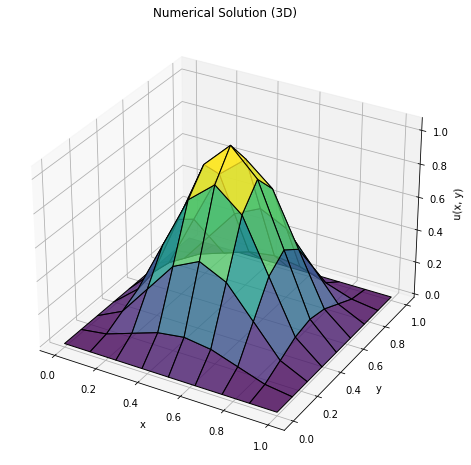

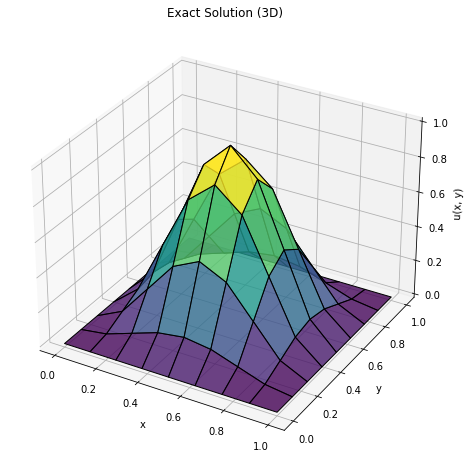

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import spsolve
from numpy.linalg import norm, eigvals

def exact_solution(x, y):
    return np.sin(np.pi * x)**2 * np.sin(np.pi * y)**2

def rhs_function(x, y):
    return 2 * np.pi**2 * (
        np.cos(2 * np.pi * x) * np.sin(np.pi * y)**2 +
        np.cos(2 * np.pi * y) * np.sin(np.pi * x)**2
    )

def jacobi_method(A, b, tol=(1e-6, 1e-6), max_its=100, x0=None):
    n = len(A)
    
    # Default initial guess if not provided
    if x0 is None:
        x0 = np.zeros(n)
    
    # Tolerance
    tol_rel, tol_abs = tol
    
    # Norm of the right-hand side vector
    norm_b = np.linalg.norm(b)
    
    # Initial guess
    x = x0
    
    # Initial residual
    r = b - np.dot(A, x)
    norm_r = np.linalg.norm(r)
    
    its = 0
    
    # Diagonal matrix D
    D = np.diag(np.diag(A))
    
    # Solve the system to get the G matrix (G = I - D^-1 * A)
    G = np.eye(n) - np.linalg.solve(D, A)
    
    # Spectral radius (max eigenvalue)
    eigenvalues = np.linalg.eigvals(G)
    ro = np.sqrt(np.max(np.abs(eigenvalues)))
    
    # Check if the method can converge (spectral radius must be less than 1)
    if ro > 1:
        print('Warning: The method cannot converge, spectral radius > 1')
    
    # Iteration
    while norm_r > tol_rel * norm_b + tol_abs and its < max_its:
        its += 1
        x = np.dot(G, x) + np.linalg.solve(D, b)
        r = b - np.dot(A, x)
        norm_r = np.linalg.norm(r)
    
    # Check if the tolerance was not reached
    if norm_r > tol_rel * norm_b + tol_abs:
        print('Warning: Could not reach the desired tolerance')
    
    return x, its, norm_r, ro


def solve_poisson_with_jacobi(N, tol=1e-12, max_its=1000):
    # Grid setup
    xmax, xmin = 1, 0
    ymax, ymin = 1, 0
    h = (xmax - xmin) / (N - 1)
    x = np.linspace(xmin, xmax, N)
    y = np.linspace(ymin, ymax, N)
    X, Y = np.meshgrid(x, y)

    # Initialize boundary conditions (zero everywhere)
    U = np.zeros((N, N))

    # Exact solution and RHS
    u_exact = exact_solution(X, Y)
    f = rhs_function(X, Y)

    # Interior points
    num_interior = N - 2

    e = np.ones(num_interior)
    T = diags([e, -2 * e, e], [-1, 0, 1], shape=(num_interior, num_interior))
    I = eye(num_interior)
    laplacian = (kron(I, T) + kron(T, I)) / h**2

    # Flatten the RHS and exclude boundary points
    f_flat = f[1:-1, 1:-1].flatten()

    # Solve using Jacobi method
    u_flat, its, norm_r, ro = jacobi_method(laplacian.toarray(), f_flat, tol=(tol, tol), max_its=max_its)

    # Reshape the solution to 2D and include boundary points
    u = np.zeros((N, N))
    u[1:-1, 1:-1] = u_flat.reshape((num_interior, num_interior))

    return X, Y, u, u_exact, its, norm_r

def main():
    # Grid size
    N = 9

    # Solve Poisson equation with Jacobi method
    X, Y, u, u_exact, its, norm_r = solve_poisson_with_jacobi(N)

    # Compute error
    error = np.max(np.abs(u - u_exact)) / np.max(np.abs(u_exact))
    print(f"Relative error: {error:.2e}")
    print(f"Iterations: {its}, Final Residual Norm: {norm_r:.2e}")

    # Plot numerical solution
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, u, 50, cmap='viridis')
    plt.colorbar(label='Numerical Solution')
    plt.title(f'Numerical Solution (Jacobi)\nIterations: {its}, Residual Norm: {norm_r:.2e}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

    # Plot exact solution
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, u_exact, 50, cmap='viridis')
    plt.colorbar(label='Exact Solution')
    plt.title('Exact Solution')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

    # Compare in 3D
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, u, cmap='viridis', edgecolor='k', alpha=0.8)
    ax.set_title('Numerical Solution (3D)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u(x, y)')
    plt.show()

    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, u_exact, cmap='viridis', edgecolor='k', alpha=0.8)
    ax.set_title('Exact Solution (3D)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u(x, y)')
    plt.show()

if __name__ == "__main__":
    main()
